# C3M2: Peer Reviewed Assignment

### Outline:
The objectives for this assignment:

1. Apply Poisson Regression to real data.
2. Learn and practice working with and interpreting Poisson Regression Models.
3. Understand deviance and how to conduct hypothesis tests with Poisson Regression.
4. Recognize when a model shows signs of overdispersion.

General tips:

1. Read the questions carefully to understand what is being asked.
2. This work will be reviewed by another human, so make sure that you are clear and concise in what your explanations and answers.

In [82]:
# Load the required packages
library(MASS)
library(ggplot2)

# Problem 1: Poisson Estimators

Let $Y_1,...,Y_n \overset{i}{\sim} Poisson(\lambda_i)$. Show that, if $\eta_i = \beta_0$, then the maximum likelihood estimator of $\lambda_i$ is $\widehat\lambda_i = \bar{Y}$, for all $i=1,...,n$.

In a Poisson distribution, the probability mass function (pmf) is given by: $P(Y_i = y_i | \lambda_i = \frac{e^{-\lambda_i}\lambda_i^{y_i}}{y_i!})$ where $Y_i$ is a random variable representing the count of events for the $i$-th observation, and $\lambda_i$ is the parameter of the poisson distribution for that observation.

Given $Y_1, Y_2,\dots,Y_n$ independent and iid poisson random variables with parameters $\lambda_1, \lambda_2,\dots,\lambda_n$, the likelihood function is the product of the individual pmfs: $L(\lambda_1, \lambda_2,\dots,\lambda_n) = \Pi^n_{i=1}P(Y_i|\lambda_i)$

So, $L(\lambda_1, \lambda_2,\dots,\lambda_n) = \Pi^n_{i=1}\frac{e^{-\lambda_i}\lambda_i^{y_i}}{y_i!}$

And, $ln\:L(\lambda_1, \lambda_2,\dots,\lambda_n) = \sum^n_{i=1}(\lambda_i + y_i\:ln(\lambda_i) - ln(y_i!))$

If we take the partial derivative with respect to $\lambda_i$: $\frac{\partial\:ln\:L}{\partial\:\lambda_i} = -1 + \frac{y_i}{\lambda_i}$

And set the derivative to 0 to find the maximum likelihood estimator: $-1 + \frac{y_i}{\hat \lambda_i} = 0$

Finally, if we solve for $\hat \lambda_i$, we get $\hat \lambda_i = y_i$

# Problem 2: Ships data

The ships dataset gives the number of damage incidents and aggregate months of service for different types of ships broken down by year of construction and period of operation. 

The code below splits the data into a training set (80% of the data) and a test set (the remaining 20%).

In [83]:
data(ships)
ships = ships[ships$service != 0,]
ships$year = as.factor(ships$year)
ships$period = as.factor(ships$period)

set.seed(11)
n = floor(0.8 * nrow(ships))
index = sample(seq_len(nrow(ships)), size = n)

train = ships[index, ]
test = ships[-index, ]
head(train)
summary(train)

,type,year,period,service,incidents
,<fct>,<fct>,<fct>,<int>,<int>
40,E,75,75,542,1
28,D,65,75,192,0
18,C,60,75,552,1
19,C,65,60,781,0
5,A,70,60,1512,6
32,D,75,75,2051,4


 type  year   period     service          incidents    
 A:5   60:7   60:11   Min.   :   45.0   Min.   : 0.00  
 B:5   65:8   75:16   1st Qu.:  318.5   1st Qu.: 0.50  
 C:6   70:8           Median : 1095.0   Median : 2.00  
 D:7   75:4           Mean   : 5012.2   Mean   :10.63  
 E:4                  3rd Qu.: 2202.5   3rd Qu.:11.50  
                      Max.   :44882.0   Max.   :58.00  

### 2. (a) Poisson Regression Fitting

Use the training set to develop an appropriate regression model for `incidents`, using `type`, `period`, and `year` as predictors (HINT: is this a count model or a rate model?).

Calculate the mean squared prediction error (MSPE) for the test set. Display your results.

In [84]:
mod <- glm(incidents ~ .-service, data = train, family = poisson)
mod


Call:  glm(formula = incidents ~ . - service, family = poisson, data = train)

Coefficients:
(Intercept)        typeB        typeC        typeD        typeE       year65  
     1.5644       1.6795      -2.0789      -1.1551      -0.5113       0.4379  
     year70       year75     period75  
     0.2260       0.1436       0.4123  

Degrees of Freedom: 26 Total (i.e. Null);  18 Residual
Null Deviance:	    554.7 
Residual Deviance: 109.2 	AIC: 200.9

In [85]:
preds <- predict(mod, newdata = test, type = "response")
actuals <- test$incidents

mse_test <- mean((actuals - preds) ** 2)
print(paste0("The mean squared prediction error for the test set is: ", round(mse_test, 4)))

[1] "The mean squared prediction error for the test set is: 131.0776"


### 2. (b) Poisson Regression Model Selection

Do we really need all of these predictors? Construct a new regression model leaving out `year` and calculate the MSE for this second model. 

Decide which model is better. Explain why you chose the model that you did.

In [86]:
mod2 <- glm(incidents ~ type + period, data = train, family = poisson)
mod2


Call:  glm(formula = incidents ~ type + period, family = poisson, data = train)

Coefficients:
(Intercept)        typeB        typeC        typeD        typeE     period75  
     1.7190       1.7831      -2.0573      -1.1281      -0.4831       0.4723  

Degrees of Freedom: 26 Total (i.e. Null);  21 Residual
Null Deviance:	    554.7 
Residual Deviance: 115.6 	AIC: 201.3

In [87]:
preds <- predict(mod2, newdata = test, type = "response")
actuals <- test$incidents

mse_test <- mean((actuals - preds) ** 2)
print(paste0("The mean squared prediction error for the test set is: ", round(mse_test, 4)))

[1] "The mean squared prediction error for the test set is: 275.1226"


In [88]:
# Can compare nested poisson models with a chi-squared
deviance_delta <- summary(mod2)$deviance - summary(mod)$deviance
df_delta <- summary(mod2)$df.resid - summary(mod)$df.resid

pchisq(deviance_delta, df_delta, lower.tail = FALSE)

[1] 0.09292038

According to the chi-squared test, at the 5% significance level, we fail to reject the null hypothesis and conclude that the `year` variable is not statistically significant. Hence, we also conclude that the model with just `type` and `period` fits well enough. This appears to be slightly contradictory to the the difference in the mean squared errors on the test dataset, which are 144.05 units different. Therefore, if the end-use of the model is for prediction then I must choose the first model irrespective of the chi-squared test results.

### 2. (c) Deviance

How do we determine if our model is explaining anything? With linear regression, we had a F-test, but we can't do that for Poisson Regression. If we want to check if our model is better than the null model, then we're going to have to check directly. In particular, we need to compare the deviances of the models to see if they're significantly different.

Conduct two $\chi^2$ tests (using the deviance). Let $\alpha = 0.05$: 

1. Test the adequacy of null model.

2. Test the adequacy of your chosen model agaisnt the saturated model (the model fit to all predictors). 

What conclusions should you draw from these tests?

In [89]:
# Test the adequacy of the null model
null_mod <- glm(incidents ~ 1, data = train, family = poisson)
null_mod

chi_sq <- pchisq(summary(null_mod)$deviance, summary(null_mod)$df.resid, lower.tail = FALSE)
print(paste0("Null model chi-squared test p-value: ", chi_sq))

# Test against the saturated model
sat_mod <- glm(incidents ~., data = train, family = poisson)
sat_mod

deviance_delta <- summary(mod)$deviance - summary(sat_mod)$deviance
df_delta <- summary(mod)$df.resid - summary(sat_mod)$df.resid

chi_sq <- pchisq(deviance_delta, df_delta, lower.tail = FALSE)
print(paste0("Chosen vs null model chi-squared test p-value: ", chi_sq))


Call:  glm(formula = incidents ~ 1, family = poisson, data = train)

Coefficients:
(Intercept)  
      2.364  

Degrees of Freedom: 26 Total (i.e. Null);  26 Residual
Null Deviance:	    554.7 
Residual Deviance: 554.7 	AIC: 630.4

[1] "Null model chi-squared test p-value: 1.5950789625333e-100"



Call:  glm(formula = incidents ~ ., family = poisson, data = train)

Coefficients:
(Intercept)        typeB        typeC        typeD        typeE       year65  
 -1.2619390   -0.2351831   -1.7277785   -0.8340264   -0.4230541    2.2424975  
     year70       year75     period75      service  
  2.9910064    2.2365673    0.8557250    0.0001153  

Degrees of Freedom: 26 Total (i.e. Null);  17 Residual
Null Deviance:	    554.7 
Residual Deviance: 27.82 	AIC: 121.5

[1] "Chosen vs null model chi-squared test p-value: 1.85320875968548e-19"


We get a statistically significant result from both tests, indicating that the chosen model is better than the null model, but worse than the saturated model.

### 2. (d) Poisson Regression Visualizations

Just like with linear regression, we can use visualizations to assess the fit and appropriateness of our model. Is it maintaining the assumptions that it should be? Is there a discernable structure that isn't being accounted for? And, again like linear regression, it can be up to the user's interpretation what is an isn't a good model.

Plot the deviance residuals against the linear predictor $\eta$. Interpret this plot.

`geom_smooth()` using formula 'y ~ x'



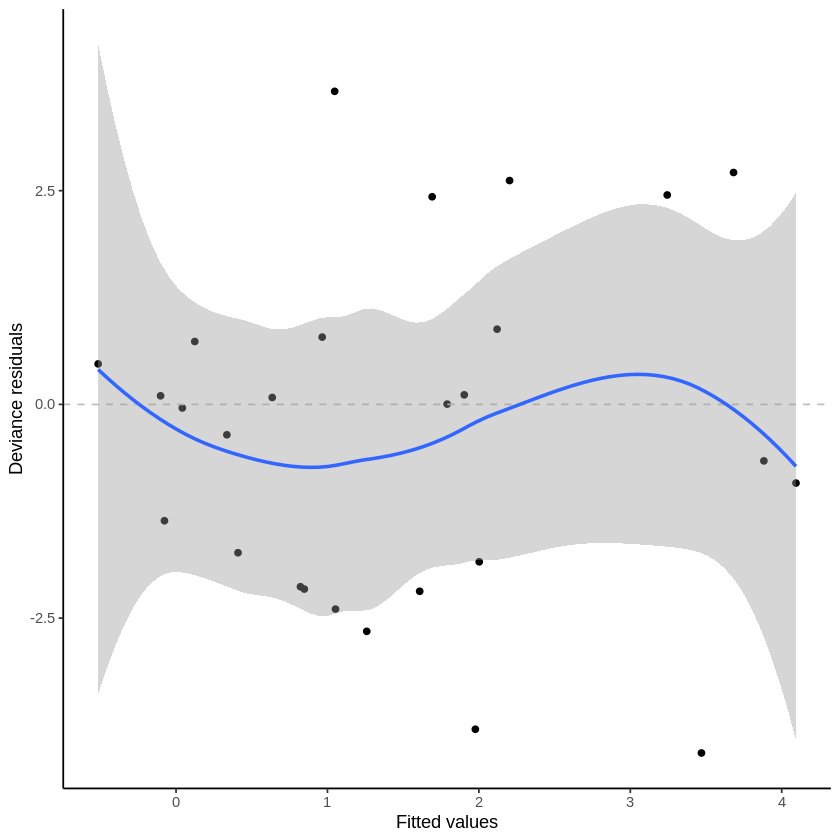

In [61]:
options(repr.plot.width = 7, repr.plot.height = 7)
p1 <- ggplot(glm_mod, aes(.fitted, .resid)) +
    geom_point() +
    geom_hline(yintercept = 0.0, col = "grey", linetype = "dashed") +
    stat_smooth(method = "loess") +
    labs(x = "Fitted values", y = "Deviance residuals") +
    theme_classic()
p1

Deviance residuals should follow an approximate standard normal distribution. This plot shows only minor deviation from that assumption, which is confirmed by the calculation of an estimated deviance parameter.

In [64]:
dp = sum(residuals(glm_mod, type = "pearson")^2) / glm_mod$df.res
dp

[1] 5.470496

### 2. (e) Overdispersion

For linear regression, the variance of the data is controlled through the standard deviation $\sigma$, which is independent of the other parameters like the mean $\mu$. However, some GLMs do not have this independence, which can lead to a problem called overdispersion. Overdispersion occurs when the observed data's variance is higher than expected, if the model is correct. 

For Poisson Regression, we expect that the mean of the data should equal the variance. If overdispersion is present, then the assumptions of the model are not being met and we can not trust its output (or our beloved p-values)!

Explore the two models fit in the beginning of this question for evidence of overdisperion. If you find evidence of overdispersion, you do not need to fix it (but it would be useful for you to know how to). Describe your process and conclusions.

In [90]:
summary(mod)
print('-----')
summary(mod2)


Call:
glm(formula = incidents ~ . - service, family = poisson, data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.0775  -1.9869  -0.0418   0.7612   3.6618  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   1.5644     0.2199   7.113 1.13e-12 ***
typeB         1.6795     0.1889   8.889  < 2e-16 ***
typeC        -2.0789     0.4408  -4.717 2.40e-06 ***
typeD        -1.1551     0.2930  -3.943 8.06e-05 ***
typeE        -0.5113     0.2781  -1.839   0.0660 .  
year65        0.4379     0.1885   2.324   0.0201 *  
year70        0.2260     0.1916   1.180   0.2382    
year75        0.1436     0.3147   0.456   0.6481    
period75      0.4123     0.1282   3.216   0.0013 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 554.70  on 26  degrees of freedom
Residual deviance: 109.21  on 18  degrees of freedom
AIC: 200.92

Number of Fisher Sc

[1] "-----"



Call:
glm(formula = incidents ~ type + period, family = poisson, data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.2377  -1.9003  -0.1372   0.6377   3.8906  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   1.7190     0.1838   9.355  < 2e-16 ***
typeB         1.7831     0.1781  10.014  < 2e-16 ***
typeC        -2.0573     0.4394  -4.683 2.83e-06 ***
typeD        -1.1281     0.2918  -3.866 0.000111 ***
typeE        -0.4831     0.2767  -1.746 0.080787 .  
period75      0.4723     0.1222   3.865 0.000111 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 554.70  on 26  degrees of freedom
Residual deviance: 115.63  on 21  degrees of freedom
AIC: 201.34

Number of Fisher Scoring iterations: 6


A common rule of thumb is that if the residual deviance is significantly greater than the degrees of freedom, then there could be overdispersion. So both models have overdispersion according to this RoT.